In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
from datetime import datetime, timedelta
from dateutil.parser import parse
import math
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize
import os

%matplotlib inline

In [3]:
plt.rcParams["figure.figsize"] = (20,10)
ufo = pd.read_csv('/Users/richardlafferty/Downloads/scrubbed.csv')
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (5,9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,28400000.0,Asia,Afghanistan,AFG,22270.0,"POLYGON ((61.21081709172574 35.65007233330923,..."
1,12799293.0,Africa,Angola,AGO,110300.0,(POLYGON ((16.32652835456705 -5.87747039146621...
2,3639453.0,Europe,Albania,ALB,21810.0,"POLYGON ((20.59024743010491 41.85540416113361,..."
3,4798491.0,Asia,United Arab Emirates,ARE,184300.0,"POLYGON ((51.57951867046327 24.24549713795111,..."
4,40913584.0,South America,Argentina,ARG,573900.0,(POLYGON ((-65.50000000000003 -55.199999999999...


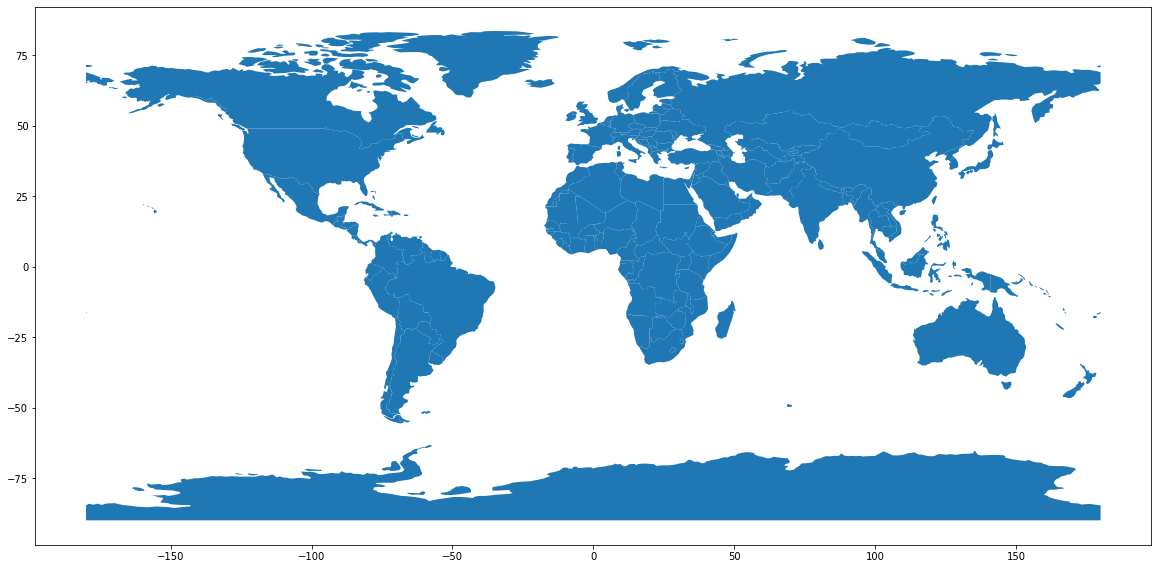

In [5]:
world.plot()


In [6]:

print(ufo.dtypes)

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                 object
longitude               float64
dtype: object


In [7]:
ufo.rename(columns = {'duration (seconds)':'duration_seconds',
                      'duration (hours/min)': 'duration_hrs_min',
                      'date posted': 'date_posted'})

,datetime,city,state,country,shape,duration_seconds,duration_hrs_min,comments,date_posted,latitude,longitude
0,10/10/1949 20:30,san marcos,tx,us,cylinder,2700,45 minutes,This event took place in early fall around 194...,4/27/2004,29.8830556,-97.941111
1,10/10/1949 21:00,lackland afb,tx,NaN,light,7200,1-2 hrs,1949 Lackland AFB&#44 TX. Lights racing acros...,12/16/2005,29.38421,-98.581082
2,10/10/1955 17:00,chester (uk/england),NaN,gb,circle,20,20 seconds,Green/Orange circular disc over Chester&#44 En...,1/21/2008,53.2,-2.916667
3,10/10/1956 21:00,edna,tx,us,circle,20,1/2 hour,My older brother and twin sister were leaving ...,1/17/2004,28.9783333,-96.645833
4,10/10/1960 20:00,kaneohe,hi,us,light,900,15 minutes,AS a Marine 1st Lt. flying an FJ4B fighter/att...,1/22/2004,21.4180556,-157.803611
5,10/10/1961 19:00,bristol,tn,us,sphere,300,5 minutes,My father is now 89 my brother 52 the girl wit...,4/27/2007,36.5950000,-82.188889
6,10/10/1965 21:00,penarth (uk/wales),NaN,gb,circle,180,about 3 mins,penarth uk circle 3mins stayed 30ft above m...,2/14/2006,51.434722,-3.180000
7,10/10/1965 23:45,norwalk,ct,us,disk,1200,20 minutes,A bright orange color changing to reddish colo...,10/2/1999,41.1175000,-73.408333
8,10/10/1966 20:00,pell city,al,us,disk,180,3 minutes,Strobe Lighted disk shape object observed clos...,3/19/2009,33.5861111,-86.286111
9,10/10/1966 21:00,live oak,fl,us,disk,120,several minutes,Saucer zaps energy from powerline as my pregna...,5/11/2005,30.2947222,-82.984167


In [8]:
ufo['date'] = ufo['datetime'].map(lambda x: str(x)[:-5])
ufo['date'] = ufo['date'].str.strip()
ufo['year'] = ufo['date'].map(lambda x: str(x)[4:])
ufo['year'] = ufo['year'].str.split('/')



In [9]:
ufo['latitude'] = pd.to_numeric(ufo['latitude'], errors = 'coerce')


In [10]:
ufo.rename(columns = {'longitude ': 'longitude'}, inplace = True)

In [11]:
print(ufo['latitude'].mean())
print(ufo['longitude'].mean())
print(ufo['latitude'].median())
print(ufo['longitude'].median())


38.12447682461752
-86.77288454711757
39.41111110000001
-87.90361109999999


In [12]:
print(ufo.dtypes)

datetime                 object
city                     object
state                    object
country                  object
shape                    object
duration (seconds)       object
duration (hours/min)     object
comments                 object
date posted              object
latitude                float64
longitude               float64
date                     object
year                     object
dtype: object


In [13]:
print(ufo.columns.to_list())

['datetime', 'city', 'state', 'country', 'shape', 'duration (seconds)', 'duration (hours/min)', 'comments', 'date posted', 'latitude', 'longitude', 'date', 'year']


In [14]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

world = world[world.name != 'Antarctica']

long_lat_points = [Point(xy) for xy in zip(ufo['longitude'], ufo['latitude'])]

crs = {"init": "epsg:4326"}


In [15]:
long_lat_points[:3]

In [16]:
shapes_seen = ufo.groupby('shape').agg(['count'])

In [17]:
print(shapes_seen)

          datetime   city  state country duration (seconds)  \
             count  count  count   count              count   
shape                                                         
changed          1      1      1       1                  1   
changing      1962   1962   1819    1710               1962   
chevron        952    952    912     863                952   
cigar         2057   2057   1894    1795               2057   
circle        7608   7608   6946    6717               7608   
cone           316    316    277     276                316   
crescent         2      2      2       1                  2   
cross          233    233    212     208                233   
cylinder      1283   1283   1195    1122               1283   
delta            7      7      7       7                  7   
diamond       1178   1178   1074    1024               1178   
disk          5213   5213   4786    4477               5213   
dome             1      1      1       0               

In [18]:
median_sighting = Point(38.1244768246185, -86.7728845471172)

In [19]:
print(gdf.head())

NameError: name 'gdf' is not defined

NameError: name 'gdf' is not defined

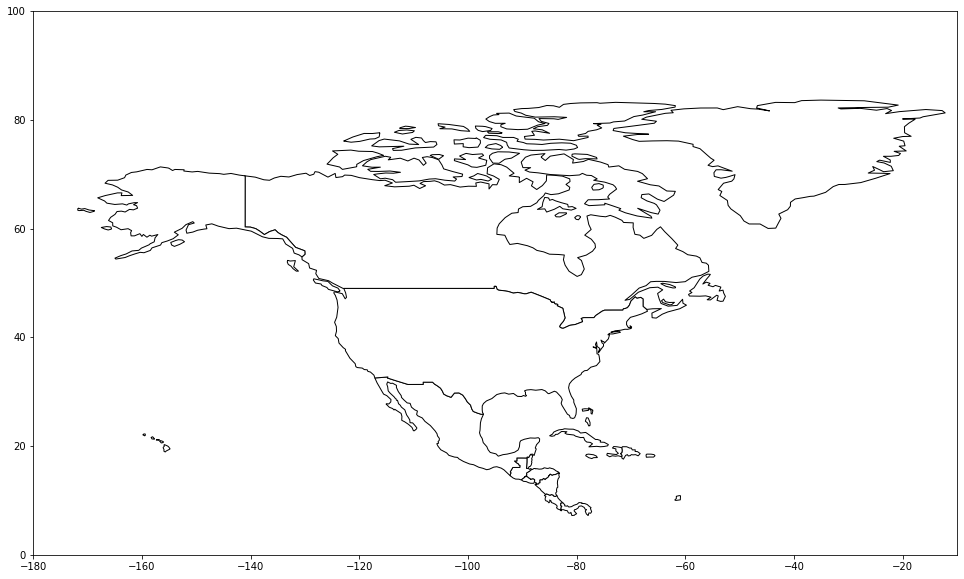

In [20]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name != 'Antarctica']

ax = world[world.continent == 'North America'].plot(color='white', edgecolor='black')
ax.set(xlim=(-180, -10), ylim=(0, 100))

gdf.head(1000).plot(ax=ax, color='green', alpha = .33)

plt.show()

NameError: name 'gdf' is not defined

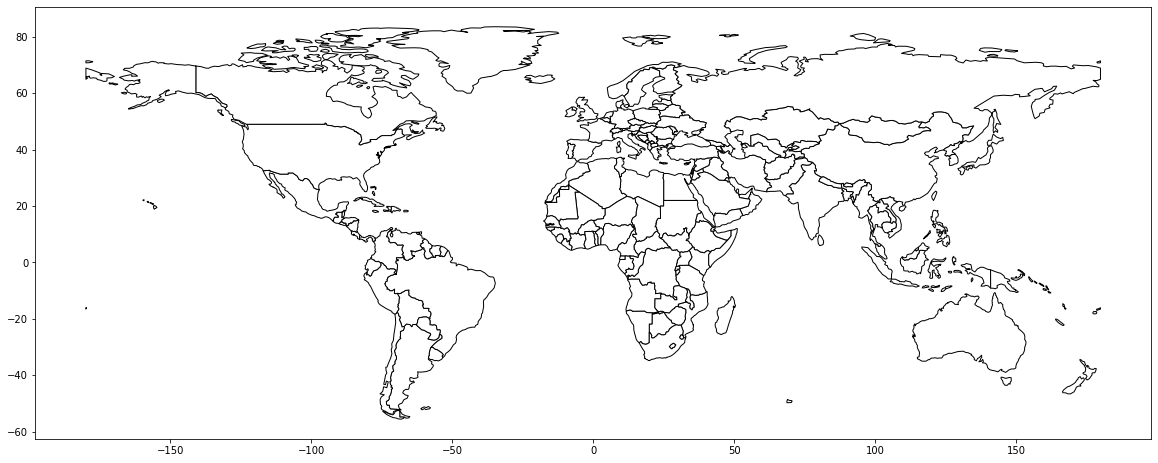

In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name != 'Antarctica']

ax = world.plot(color='white', edgecolor='black')

gdf.head(10000).plot(ax=ax, color='green', alpha = .33)

plt.show()

In [22]:
print(ufo.head())

           datetime                  city state country     shape  \
0  10/10/1949 20:30            san marcos    tx      us  cylinder   
1  10/10/1949 21:00          lackland afb    tx     NaN     light   
2  10/10/1955 17:00  chester (uk/england)   NaN      gb    circle   
3  10/10/1956 21:00                  edna    tx      us    circle   
4  10/10/1960 20:00               kaneohe    hi      us     light   

  duration (seconds) duration (hours/min)  \
0               2700           45 minutes   
1               7200              1-2 hrs   
2                 20           20 seconds   
3                 20             1/2 hour   
4                900           15 minutes   

                                            comments date posted   latitude  \
0  This event took place in early fall around 194...   4/27/2004  29.883056   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  12/16/2005  29.384210   
2  Green/Orange circular disc over Chester&#44 En...   1/21/2008  53.200000  

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


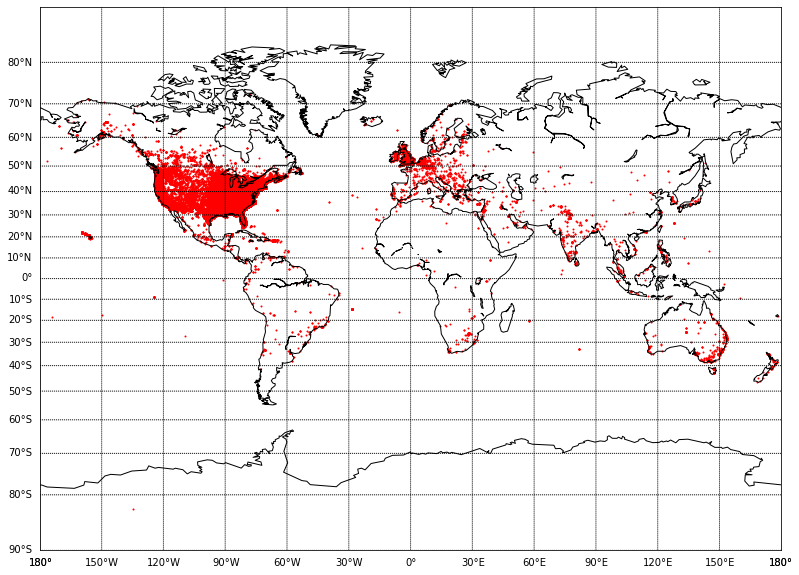

In [23]:
m = Basemap(projection = 'mill',
           llcrnrlat = -90,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])

m.scatter(ufo.longitude.to_list(), ufo.latitude.to_list(), latlon = True, s = 1, c = 'red')


In [24]:
light = ufo.loc[ufo['shape'] == 'light']

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


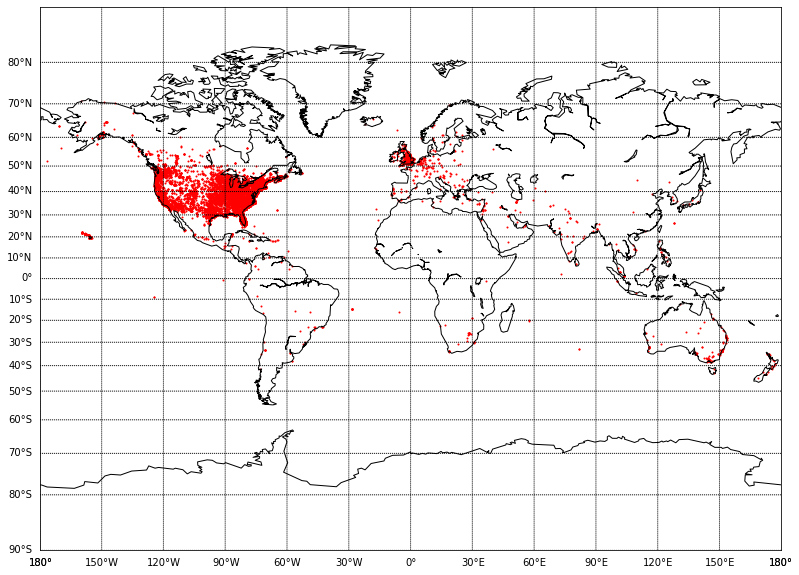

In [25]:
m = Basemap(projection = 'mill',
           llcrnrlat = -90,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])

m.scatter(light.longitude.to_list(), light.latitude.to_list(), latlon = True, s = 1, c = 'red')

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys


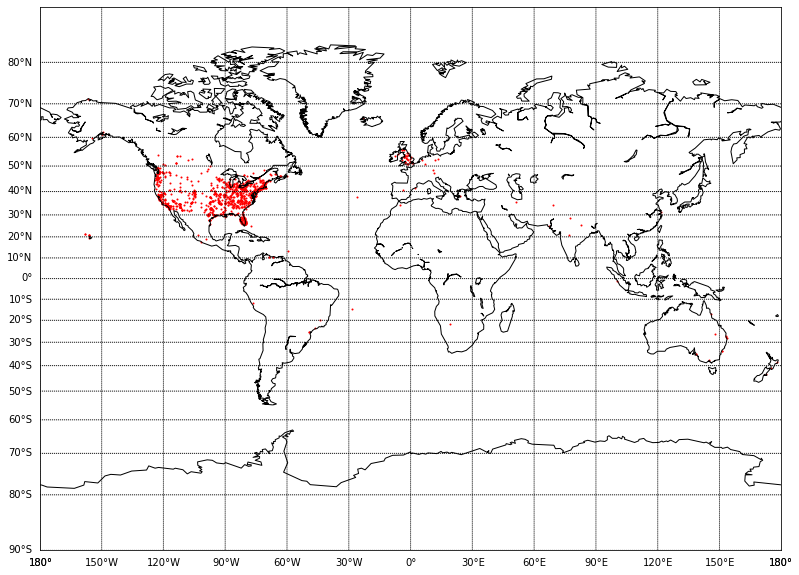

In [26]:
cylinder = ufo.loc[ufo['shape'] == 'cylinder']
m = Basemap(projection = 'mill',
           llcrnrlat = -90,
           urcrnrlat = 90,
           llcrnrlon = -180,
           urcrnrlon = 180,
           resolution = 'c')
m.drawcoastlines()
m.drawparallels(np.arange(-90, 90, 10), labels = [True, False, False, False])
m.drawmeridians(np.arange(-180, 180, 30), labels = [0, 0, 0, 1])

m.scatter(cylinder.longitude.to_list(), cylinder.latitude.to_list(), latlon = True, s = 1, c = 'red')

/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  
/Users/richardlafferty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


(56,
 5,
 [-179.231086, -14.601813, 0.0, 0.0],
 [179.859681, 71.439786, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x1a3077f6a0>)

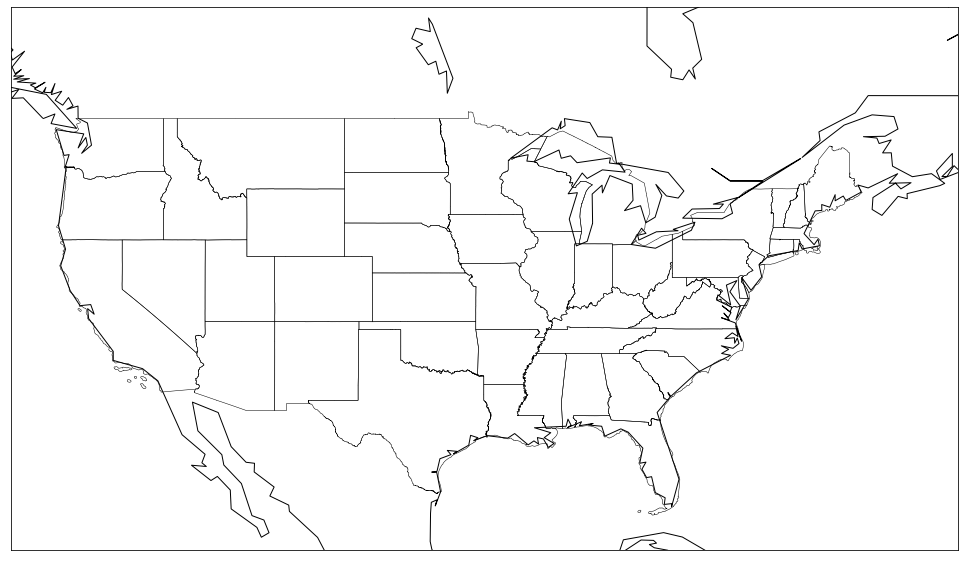

In [29]:
m = Basemap(projection = 'mill',
           llcrnrlat = 22,
           urcrnrlat = 55,
           llcrnrlon = -128,
           urcrnrlon = -60,
           resolution = 'c')
m.drawcoastlines()
m.readshapefile('/Users/richardlafferty/Downloads/tl_2017_us_state/tl_2017_us_state', 'areas')